<a href="https://colab.research.google.com/github/vsinyutsina/hft_final_qw/blob/main/%D0%9F%D1%80%D0%B8%D0%BC%D0%B5%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5_%D1%81%D0%B0%D0%BC%D1%8B%D1%85_%D0%BF%D1%80%D0%BE%D1%81%D1%82%D1%8B%D1%85_%D1%81%D1%82%D1%80%D0%B0%D1%82%D0%B5%D0%B3%D0%B8%D0%B8%CC%86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from math import sqrt

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
shares = {
            'Microsoft': 'MSFT',
            'Apple': 'AAPL',
            'NVIDIA': 'NVDA',
            'Amazon': 'AMZN',
            'Alphabet': 'GOOG',
            'Tesla': 'TSLA',
            'Broadcom': 'AVGO',
            'Meta': 'META',
            'Costco': 'COST',
            'Netflix': 'NFLX'
        }
crypto = {
            'Bitcoin': 'BTC',
            'Ethereum': 'ETH',
            'Tether': 'USDT',
            'Binance': 'BNB',
            'Solana': 'SOL',
            'XRP': 'XRP',
            'Cardano': 'ADA',
            'Dogecoin': 'DOGE',
            'Toncoin': 'TON'
        }

In [5]:
df_hft_old = pd.read_csv('hft_data.csv')
df_hft_first = pd.read_csv('hft_data (1).csv')
df_hft_second = pd.read_csv('hft_data_3.csv')
df_hft_third = pd.read_csv('hft_data_part4.csv')
df_hft = pd.concat([df_hft_old, df_hft_first, df_hft_second, df_hft_third])
df_hft.head()

,Datetime,Close,High,Low,Open,Volume,share_name,ticker_name
0,2025-02-03 14:30:00+00:00,410.720001,411.980011,409.119995,411.760010,1942143.0,Microsoft,MSFT
1,2025-02-03 14:31:00+00:00,411.290009,411.500000,410.000000,410.734985,174765.0,Microsoft,MSFT
2,2025-02-03 14:32:00+00:00,413.320007,413.320007,411.399994,411.399994,174173.0,Microsoft,MSFT
3,2025-02-03 14:33:00+00:00,412.850006,413.950012,412.850006,413.269989,162649.0,Microsoft,MSFT
4,2025-02-03 14:34:00+00:00,412.934998,413.160004,412.630005,412.804993,120189.0,Microsoft,MSFT


In [6]:
df_hft['Datetime'] = pd.to_datetime(df_hft['Datetime'])
df_hft['Datetime'] = df_hft['Datetime'].dt.tz_convert(None)

df_hft.sort_values(['ticker_name', 'Datetime'], inplace=True)

In [7]:
df_hft.Datetime.max()

Timestamp('2025-04-25 19:59:00')

# Мини-версия предсказания

In [ ]:
import pandas as pd
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

def train_test_series_split(df, test_size=0.2):

    train_size = int(len(series) * (1 - test_size))
    train, test = series[:train_size], series[train_size:]

    return train, test


def train_and_predict_ses(series, test_size=0.1):

    train, test = train_test_series_split(series, test_size=test_size)

    model = SimpleExpSmoothing(series)
    model_fit = model.fit(optimized=True)

    forecast = model_fit.forecast(steps=len(test))

    return model, forecast, train, test

In [ ]:
# Группируем данные по ticker_name
grouped = df_hft.groupby('ticker_name')['Target']

# Создаем словарь для хранения результатов
results_ses = {}

# Итерируемся по каждой группе (акции) и обучаем модель
for ticker, series in grouped:
    print(f"Обучение модели для {ticker}...")
    series = series[~series.isna()]
    model, predictions, train, test = train_and_predict_ses(series)
    rmse = sqrt(mean_squared_error(test, predictions))
    mape = mean_absolute_percentage_error(test, predictions)
    results_ses[ticker] = {'predictions': predictions, 'rmse': rmse,
                       'mape': mape, 'model': model, 'train': train, 'test': test}
    print(f"MAPE для {ticker}: {mape:.4f}")
    print("-" * 20)

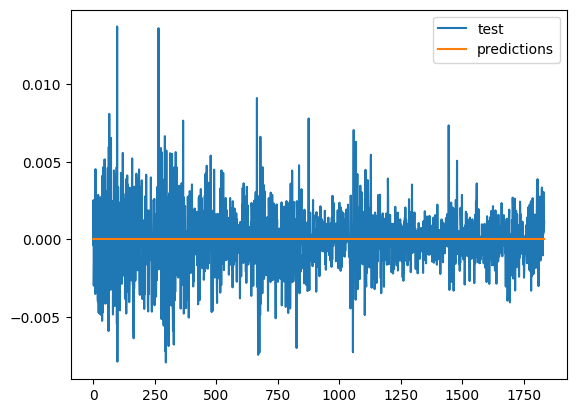

In [ ]:
import matplotlib.pyplot as plt

tsla = results_ses['TSLA']
plt.plot(tsla['test'].reset_index(drop=True))
plt.plot(tsla['predictions'].reset_index(drop=True))
plt.legend(['test', 'predictions'])
plt.show()

In [ ]:
df_result = pd.DataFrame([(ticker, result['rmse'], result['mape']) for ticker, result in results_ses.items()],
                         columns=['ticker_name', 'rmse_ses', 'mape_ses'])
df_result

,ticker_name,rmse_ses,mape_ses
0,AAPL,0.001575,1.359218e+09
1,AMZN,0.001336,5.988727e+09
2,AVGO,0.001813,3.021134e+09
3,BTC,0.000848,3.849262e+09
4,COST,0.001001,4.094575e+10
5,ETH,0.001412,6.031883e+11
6,GOOG,0.001090,8.665734e+09
7,META,0.001472,1.012082e+09
8,MSFT,0.001014,2.740629e+08
9,NFLX,0.001305,1.795367e+09


In [ ]:
def train_and_predict_hw(series, test_size=0.2):

    train, test = train_test_series_split(series, test_size=0.2)

    model = ExponentialSmoothing(series, seasonal_periods=60,
                                 trend='add', seasonal='add')  # seasonal_periods = период сезонности
    model_fit = model.fit(optimized=True)

    forecast = model_fit.forecast(steps=len(test))

    return model, forecast, train, test

In [ ]:
# Создаем словарь для хранения результатов
results_hw = {}

# Итерируемся по каждой группе (акции) и обучаем модель
for ticker, series in grouped:
    if ticker == 'USDC':
      continue
    print(f"Обучение модели для {ticker}...")
    series = series[~series.isna()]
    model, predictions, train, test = train_and_predict_hw(series)
    rmse = sqrt(mean_squared_error(test, predictions))
    mape = mean_absolute_percentage_error(test, predictions)
    results_hw[ticker] = {'predictions': predictions, 'rmse': rmse,
                       'mape': mape, 'model': model, 'train': train, 'test': test}
    print(f"MAPE для {ticker}: {mape:.4f}")

Обучение модели для AAPL...
MAPE для AAPL: 5041687924.4448
Обучение модели для AMZN...
MAPE для AMZN: 5277107368.5965
Обучение модели для AVGO...
MAPE для AVGO: 5737571616.7411
Обучение модели для BTC...
MAPE для BTC: 87079458337.2491
Обучение модели для COST...
MAPE для COST: 12575610329.1852
Обучение модели для ETH...
MAPE для ETH: 80767322912.9755
Обучение модели для GOOG...
MAPE для GOOG: 7787539617.2342
Обучение модели для META...
MAPE для META: 764837215.1737
Обучение модели для MSFT...
MAPE для MSFT: 2396018660.7865
Обучение модели для NFLX...
MAPE для NFLX: 3407812714.6442
Обучение модели для NVDA...
MAPE для NVDA: 3665845506.1723
Обучение модели для SOL...
MAPE для SOL: 1428872333629.0435
Обучение модели для TSLA...
MAPE для TSLA: 2068713541.8196


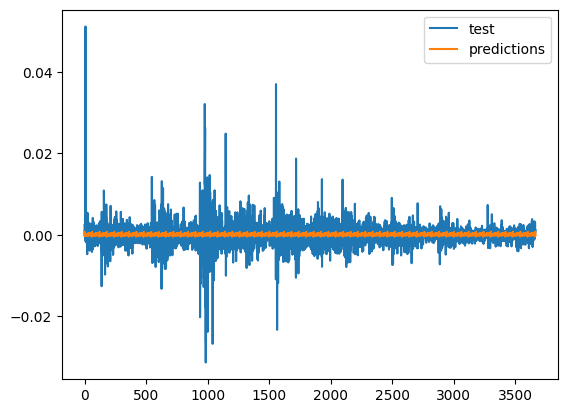

In [ ]:
import matplotlib.pyplot as plt

tsla = results_hw['TSLA']
plt.plot(tsla['test'].reset_index(drop=True))
plt.plot(tsla['predictions'].reset_index(drop=True))
plt.legend(['test', 'predictions'])
plt.show()

# Новые признаки для классического ML

In [8]:
import math

def new_time_features(data):
  data['minute'] = data.Datetime.dt.minute
  data['hour'] = data.Datetime.dt.hour
  data['day'] = data.Datetime.dt.day
  data['weekday'] = data.Datetime.dt.weekday

  d_time = [('minute', 60), ('hour', 24), ('day', 31), ('weekday', 7)]

  for col_name, period in d_time:
    data[col_name + '_sin'] = np.sin(2 * np.pi * data[col_name] / period)
    data[col_name + '_cos'] = np.cos(2 * np.pi * data[col_name] / period)
    data[col_name] = data[col_name].apply(str)

  return data


def new_price_features(data):

  close = data['Close']
  high = data['High']
  low = data['Low']
  open_price = data['Open']

  data['median_price'] = (high + low) / 2
  data['weighted_close'] = (high + low + close * 2) / 4
  data['price_range'] = (high - low)
  data['price_body'] = (close - open_price)
  data['price_body_abs'] = np.abs(close - open_price)
  data['price_body_relative'] = data['price_body']/data['price_range']

  return data


def recognize_candlestick_patterns(df):
  """Добавляет признаки для свечных паттернов."""

  close = df['Close']
  high = df['High']
  low = df['Low']
  open_price = df['Open']

  # 1. Doji
  df['is_doji'] = np.where(abs(close - open_price) <= 0.01 * (high - low), 1, 0)  # Тело очень маленькое
  # 2. Hammer (Молот)
  df['is_hammer'] = np.where(
      ((high - low) > 3 * (open_price - close)) &  # Большой нижний хвост
      ((close - low) <= 0.3 * (high - low)) &    # Маленькое тело в верхней части диапазона
      ((open_price - low) <= 0.3 * (high - low)),  # Маленькое тело в верхней части диапазона
      1, 0
  )

  # 3. Engulfing (Поглощение) - Bullish and Bearish
  df['is_bullish_engulfing'] = np.where(
      (open_price.shift(1) > close.shift(1)) &  # Предыдущая свеча медвежья
      (open_price < close) &                    # Текущая свеча бычья
      (open_price < close.shift(1)) &        # Текущая свеча открылась ниже закрытия предыдущей
      (close > open_price.shift(1)),            # Текущая свеча закрылась выше открытия предыдущей
      1, 0
  )
  df['is_bearish_engulfing'] = np.where(
      (open_price.shift(1) < close.shift(1)) &  # Предыдущая свеча бычья
      (open_price > close) &                    # Текущая свеча медвежья
      (open_price > close.shift(1)) &        # Текущая свеча открылась выше закрытия предыдущей
      (close < open_price.shift(1)),            # Текущая свеча закрылась ниже открытия предыдущей
      1, 0
  )
  # Объединим в один флаг
  df['is_engulfing'] = np.where((df['is_bullish_engulfing']==1) | (df['is_bearish_engulfing']==1),1,0)


  # 4. Morning Star / Evening Star (Упрощенная версия) - Звезда (Точнее упрощенный вариант)
  df['is_star'] = np.where(
      (abs(close.shift(1) - open_price.shift(1)) > 2 * abs(open_price.shift(1) - close.shift(1))) & # Предыдущая свеча большая
      (abs(close.shift(2) - open_price.shift(2)) > 2 * abs(open_price.shift(2) - close.shift(2))) & # Свеча перед ней тоже большая
      (abs(close - open_price) > 2 * abs(open_price - close)) & # Текущая свеча большая
      (abs(open_price.shift(1) - ((high.shift(1)+low.shift(1))/2)) < 0.01*(high.shift(1)-low.shift(1))), # промежуточная свеча это подобие доджи (значит звезда)

      1, 0
  )

  return df


def new_returns_features(data):
  lags = [1, 2, 3, 4, 14, 29, 59]

  data['simple_return'] = (data.Close - data.Close.shift(1))/data.Close.shift(1)
  data['log_return'] = np.log(data.Close/data.Close.shift(1))

  for lag in lags:
    data['log_return_lag_' + str(lag)] = data.log_return.shift(lag)
    data['simple_return_lag_' + str(lag)] = data.simple_return.shift(lag)

  return data


def new_volatility_features(data):
  """Рассчитывает различные показатели волатильности."""

  close = data['Close']
  high = data['High']
  low = data['Low']
  open_price = data['Open']
  lags = [1, 2, 3, 5, 15, 30, 60]

  data['simple_return'] = (close - close.shift(1))/close.shift(1)
  data['log_return'] = np.log(close / close.shift(1))

  for lag in lags:
    # 1. Historical Volatility (HV) - Стандартное отклонение логарифмических доходностей
    data['historical_volatility'] = data['log_return'].rolling(window=lag).std()
    # 2. Parkinson Volatility (Использует High и Low)
    data['parkinson_volatility'] = 0.361 * (np.log(high / low)**2).rolling(window=lag).sum() / lag
    # 3. Garman-Klass Volatility (Использует Open, High, Low, Close)
    log_ho = np.log(high / open_price)
    log_lo = np.log(low / open_price)
    log_co = np.log(close / open_price)
    data['garman_klass_volatility'] = (0.5 * log_ho**2 - (2*np.log(2)-1) * log_co**2).rolling(window=lag).sum() / lag
    # 4. Rogers-Satchell Volatility (Подходит для рядов с гэпами)
    log_hc = np.log(high / close.shift(1))
    log_lc = np.log(low / close.shift(1))
    data['rogers_satchell_volatility'] = (log_hc * (log_hc - log_co) + log_lc * (log_lc - log_co)).rolling(window=lag).sum() / lag

  return data


def new_statistics_features(data):
  lags = [1, 2, 3, 5, 15, 30, 60]

  for lag in lags:
    data['ratio_lag_' + str(lag)] = data.Close.shift(lag)
    data['ratio_diff_lag_' + str(lag)] = data.Close - data['ratio_lag_' + str(lag)]

  # Example: EMA (Exponential Moving Average)
  for lag in lags[3:]:
      data['ratio_mean_lag_' + str(lag)] = data.Close.rolling(lag, min_periods=1).mean()
      data['ratio_diff_mean_lag_' + str(lag)] = data.Close - data['ratio_mean_lag_' + str(lag)]
      data['ema_' + str(lag)] = data['Close'].ewm(span=lag, adjust=False).mean()

  for lag in lags[3:]:
    data['ratio_max_lag_' + str(lag)] = data.Close.rolling(lag, min_periods=1).max()
    data['ratio_min_lag_' + str(lag)] = data.Close.rolling(lag, min_periods=1).min()
    data['ratio_q25_lag_' + str(lag)] = data.Close.rolling(lag, min_periods=1).quantile(0.25)
    data['ratio_q75_lag_' + str(lag)] = data.Close.rolling(lag, min_periods=1).quantile(0.75)

  return data


def new_volume_features(data):
  lags = [1, 2, 3, 5, 15]
  close = data['Close']
  high = data['High']
  low = data['Low']
  open_price = data['Open']
  volume = data['Volume']
  typical_price = (high + low + close) / 3

  data['accum_dist'] = ((close - low) - (high - close))/(high - low) * volume

  for window in lags:
    # 1. Volume-Weighted Average Price (VWAP)
    data['vwap'] = (volume * typical_price).rolling(window=window).sum() / volume.rolling(window=window).sum()
    # 2. On-Balance Volume (OBV)
    data['obv'] = np.where(close > close.shift(1), volume, np.where(close < close.shift(1), -volume, 0)).cumsum()
    # 3. Accumulation/Distribution Line (A/D)
    money_flow_multiplier = ((close - low) - (high - close)) / (high - low)
    money_flow_volume = money_flow_multiplier * volume
    data['ad_line'] = money_flow_volume.cumsum()

  return data

In [9]:
def create_all_features(df):

    df = df.groupby('ticker_name', group_keys=False).apply(new_price_features)
    df = df.groupby('ticker_name', group_keys=False).apply(new_returns_features)
    df = df.groupby('ticker_name', group_keys=False).apply(new_volatility_features)
    df = df.groupby('ticker_name', group_keys=False).apply(new_statistics_features)
    df = df.groupby('ticker_name', group_keys=False).apply(new_volume_features)

    return df

In [10]:
def reset_dataset():
  df_classic = df_hft.copy()

  df_classic = new_time_features(df_classic)
  df_classic = recognize_candlestick_patterns(df_classic)
  df_classic = create_all_features(df_classic)
  df_classic.dropna(inplace=True)

  return df_classic

In [11]:
df_classic = reset_dataset()
df_classic.head()

,Datetime,Close,High,Low,Open,Volume,share_name,ticker_name,minute,hour,...,ratio_q25_lag_30,ratio_q75_lag_30,ratio_max_lag_60,ratio_min_lag_60,ratio_q25_lag_60,ratio_q75_lag_60,accum_dist,vwap,obv,ad_line
1996,2025-02-03 15:30:00,229.619995,229.809906,229.139999,229.259995,304109.0,Apple,AAPL,30,15,...,227.202507,228.083755,231.729996,226.639893,227.770004,229.972500,131686.130766,228.265406,-2794845.0,1.869675e+06
1997,2025-02-03 15:31:00,229.552505,229.819901,229.479996,229.649994,217576.0,Apple,AAPL,31,15,...,227.202507,228.325001,231.729996,226.639893,227.770004,229.917496,-124747.740707,228.391826,-3012421.0,1.744928e+06
1998,2025-02-03 15:32:00,229.570007,229.779999,229.490005,229.544998,247963.0,Apple,AAPL,32,15,...,227.202507,228.442505,231.729996,226.639893,227.770004,229.851254,-111149.528913,228.522354,-2764458.0,1.633778e+06
1999,2025-02-03 15:33:00,229.434998,229.669998,229.300003,229.580002,230083.0,Apple,AAPL,33,15,...,227.202507,228.589382,231.729996,226.639893,227.770004,229.831253,-62189.210739,228.645363,-2994541.0,1.571589e+06
2000,2025-02-03 15:34:00,229.500000,229.720001,229.460007,229.460007,161465.0,Apple,AAPL,34,15,...,227.202507,228.795631,231.729996,226.639893,227.770004,229.811245,-111790.750924,228.738464,-2833076.0,1.459798e+06


In [12]:
df_classic.shape, df_hft.shape

((217488, 98), (249164, 8))

# Базовые функции и импорты

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor

In [14]:
def take_first_80_percent(group):
  group = group.reset_index(drop=True)
  n = group.shape[0]
  take_count = int(n * 0.8)  # Количество строк, которые нужно взять
  group['split'] = None
  group.loc[:take_count-1, 'split'] = 'train'
  group.loc[take_count:, 'split'] = 'test'
  return group


def train_test_split_series_split(df, test_size=0.2, target_col='Target', group_col='ticker_name'):
  df.sort_values('Datetime', inplace=True)

  data = df.groupby(group_col, group_keys=False).apply(take_first_80_percent)
  train, test = data.query('split == "train"'), data.query('split == "test"')

  y_train = train[target_col]
  y_test = test[target_col]
  X_train = train.drop([target_col, 'split'], axis=1)
  X_test = test.drop([target_col, 'split'], axis=1)

  return X_train, X_test, y_train, y_test

In [15]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

class TradingPipeline(BaseEstimator, RegressorMixin):
    """
    A class to encapsulate a trading strategy with tunable preprocessing and model parameters.

    Attributes:
        numeric_transformer: Transformer for numeric features (e.g., StandardScaler)
        categorical_transformer: Transformer for categorical features (e.g., OneHotEncoder)
        model: The scikit-learn compatible regression model
        numeric_features (list): List of numeric feature names
        categorical_features (list): List of categorical feature names
    """

    def __init__(
        self,
        model,
        numeric_features,
        categorical_features,
        numeric_transformer=StandardScaler(),
        categorical_transformer=OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    ):
        self.model = model
        self.numeric_features = numeric_features
        self.categorical_features = categorical_features
        self.numeric_transformer = numeric_transformer
        self.categorical_transformer = categorical_transformer

        # Создаем компоненты пайплайна
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', self.numeric_transformer, self.numeric_features),
                ('cat', self.categorical_transformer, self.categorical_features)
            ],
            remainder='drop'
        )

        self.pipeline = Pipeline([
            ('preprocessor', self.preprocessor),
            ('model', self.model)
        ])

    def fit(self, X, y):
        self.pipeline.fit(X, y)
        return self

    def predict(self, X):
        return self.pipeline.predict(X)

    def evaluate(self, X, y, metric):
        y_pred = self.predict(X)
        return metric(y[y != 0], y_pred[y != 0])

In [16]:
import pandas as pd
import numpy as np
import math

def simulate_trades_smart_multi_buy(df, predictions, initial_capital=100000, commission_rate=0.001,
                                      threshold_buy=0.01, threshold_sell=-0.01,
                                      risk_per_trade=0.01,  # % of capital to risk per trade
                                      min_trade_size=1,    # Minimum number of shares per trade
                                      max_position_size=None  # Optional: Max number of shares per ticker
                                      ):
    """
    Simulates trading across multiple stocks with improved decision-making, risk management,
    and the ability to buy *different* stocks at different times.

    Args:
        df (pd.DataFrame): DataFrame with closing prices ('Close') indexed by ('ticker', 'date').
                           Requires a MultiIndex (ticker, date).
        predictions (dict): Dictionary of predictions, where keys are tuples (ticker, date) and
                            values are the predicted price change (e.g., percentage).
        initial_capital (float): Starting capital.
        commission_rate (float): Commission rate per trade (percentage).
        threshold_buy (float): Threshold for buying (predicted price change).
        threshold_sell (float): Threshold for selling (predicted price change).
        risk_per_trade (float): Percentage of capital to risk on each trade (e.g., 0.01 = 1%).
        min_trade_size (int): Minimum number of shares to buy or sell.
        max_position_size (int, optional): Maximum number of shares allowed per stock. If None, no limit.

    Returns:
        pd.DataFrame: DataFrame with trade information, indexed by (ticker, date).
    """

    # Initialize portfolio
    portfolio = {}  # {ticker: {cash, positions, last_action}}
    trades = []  # List to store trade details
    df['Close'] = df['Close'].astype(np.float64)

    for (ticker, date), predicted_change in predictions.items():

        if (ticker, date) not in df.index:
          continue  # Skip if no data for this (ticker, date)

        current_price = df.loc[(ticker, date), 'Close']
        # Initialize ticker in portfolio if it doesn't exist
        if ticker not in portfolio:
            portfolio[ticker] = {
                'cash': initial_capital,
                'positions': 0,
                'last_action': 'none',
            }
        cash = portfolio[ticker]['cash']
        positions = portfolio[ticker]['positions']
        last_action = portfolio[ticker]['last_action']

        # 1. Determine Action: BUY, SELL, HOLD
        action = 'hold'
        shares_to_trade = 0  # Number of shares to trade

        # BUY Condition
        if predicted_change > threshold_buy and last_action != 'buy':
            action = 'buy'

        # SELL Condition
        elif predicted_change < threshold_sell and last_action != 'sell' and positions > 0:
            action = 'sell'

        # 2. Trade Execution & Risk Management
        if action == 'buy':
            # a. Calculate Position Size (Risk-Based)
            risk_amount = cash * risk_per_trade  # Amount to risk on this trade
            # Adjust shares_to_buy to account for commission and min trade size
            shares_to_buy = math.floor(risk_amount / (current_price * (1 + commission_rate)))
            shares_to_buy = max(min_trade_size, shares_to_buy)  # Apply minimum trade size

            if max_position_size is not None:  # Apply max position size
                shares_to_buy = min(shares_to_buy, max_position_size - positions)  # Avoid exceeding max position size

            if shares_to_buy > 0:
                cost = shares_to_buy * current_price * (1 + commission_rate)
                if cost <= cash:
                    cash -= cost
                    positions += shares_to_buy
                    portfolio[ticker]['cash'] = cash
                    portfolio[ticker]['positions'] = positions
                    portfolio[ticker]['last_action'] = 'buy'
                else:
                    shares_to_buy = 0
                    action = 'hold'  # Not enough cash

        elif action == 'sell' and positions > 0:
            shares_to_sell = min(positions, min_trade_size)  # Sell at least min_trade_size, but no more than we have
            if shares_to_sell > 0:
                cash_from_sell = shares_to_sell * current_price * (1 - commission_rate)
                cash += cash_from_sell
                positions -= shares_to_sell
                portfolio[ticker]['cash'] = cash
                portfolio[ticker]['positions'] = positions
                portfolio[ticker]['last_action'] = 'sell'

        # Record Trade Details
        trades.append({
            'ticker': ticker,
            'date': date,
            'action': action,
            'price': current_price,
            'shares': shares_to_trade if action == "buy" else (shares_to_sell if action == "sell" else 0),  # Number of shares traded
            'cash': portfolio[ticker]['cash'],
            'positions': portfolio[ticker]['positions'],
            'total_value': portfolio[ticker]['cash'] + portfolio[ticker]['positions'] * current_price
        })

        # Update portfolio after processing this date
        portfolio[ticker]['cash'] = cash  # Update cash
        portfolio[ticker]['positions'] = positions
        portfolio[ticker]['last_action'] = last_action # update last action

    trades_df = pd.DataFrame(trades)
    trades_df.set_index(['ticker', 'date'], inplace=True)
    return trades_df

In [17]:
import pandas as pd
import numpy as np

def analyze_trades(trades_df, initial_capital=100000):
    """
    Анализирует результаты симуляции торговли и рассчитывает показатели прибыльности.

    Args:
        trades_df (pd.DataFrame): DataFrame с результатами симуляции (возвращенный функцией simulate_trades).
        initial_capital (float): Начальный капитал.

    Returns:
        dict: Словарь с показателями прибыльности.
    """

    # 1. Рассчитываем прибыль/убыток по каждой сделке
    trades_df['trade_profit'] = 0.0  # Инициализируем столбец

    # Цикл по каждой строке, вычисляем профит и помещаем его в колонку trade_profit
    for i in range(1, len(trades_df)):
        previous_total_value = trades_df['total_value'].iloc[i-1]
        current_total_value = trades_df['total_value'].iloc[i]

        trade_profit = current_total_value - previous_total_value
        trades_df['trade_profit'].iloc[i] = trade_profit

    # 2. Рассчитываем кумулятивную прибыль
    trades_df['cumulative_profit'] = trades_df['trade_profit'].cumsum()

    # 3. Рассчитываем общий доход
    total_profit = trades_df['cumulative_profit'].iloc[-1]

    # 4. Рассчитываем процентную доходность
    total_return = (total_profit / initial_capital) * 100

    # 5. Рассчитываем максимальную просадку (Maximum Drawdown)
    # Считаем кумулятивную максимальную прибыль
    trades_df['cumulative_max'] = trades_df['total_value'].cummax()
    # Просадка - это разница между кумулятивной максимальной прибылью и текущей стоимостью
    trades_df['drawdown'] = trades_df['cumulative_max'] - trades_df['total_value']
    # Максимальная просадка - это максимальное значение просадки
    max_drawdown = trades_df['drawdown'].max()

    # 6. Дополнительные метрики (при желании)
    num_winning_trades = len(trades_df[trades_df['trade_profit'] > 0])
    num_losing_trades = len(trades_df[trades_df['trade_profit'] < 0])
    win_rate = (num_winning_trades / (num_winning_trades + num_losing_trades)) * 100 if (num_winning_trades + num_losing_trades) > 0 else 0

    # 7. Собираем результаты в словарь
    analysis_results = {
        'Total Profit': total_profit,
        'Total Return (%)': total_return,
        'Maximum Drawdown': max_drawdown,
        'Win Rate (%)': win_rate,
        'Number of Winning Trades': num_winning_trades,
        'Number of Losing Trades': num_losing_trades
    }

    return analysis_results

В зависимости от стратегии, есть разные варианты выбора таргета.

# Вариант 1.  Magnitude of Price Change (Величина изменения цены)

In [18]:
def create_target_magnitude(df, future_period=1):
    """Создает целевую переменную для величины изменения цены."""
    df['Future_Price'] = df['Close'].shift(-future_period)
    df['Target'] = (df['Future_Price'] - df['Close'])
    df = df.drop(['Future_Price'], axis=1)
    df.dropna(inplace=True)
    return df

# Линейная регрессия - бейзлайн

In [ ]:
if __name__ == '__main__':

    df_classic = reset_dataset()
    df_classic = df_classic.groupby('ticker_name', group_keys=False).apply(create_target_magnitude)

    X_train, X_test, y_train, y_test = train_test_split_series_split(df_classic)

    numeric_features = X_train.select_dtypes(include=['number']).columns.tolist()  # Автоматический выбор числовых столбцов
    categorical_features = ['ticker_name']
    target_column = 'Target'

    model = LinearRegression()

    pipeline = TradingPipeline(model, numeric_features, categorical_features)
    pipeline.fit(X_train, y_train)

    predictions = pipeline.predict(X_test)

    mse = pipeline.evaluate(X_test, y_test, mean_squared_error)
    mape = pipeline.evaluate(X_test, y_test, mean_absolute_percentage_error)

    print(f"MSE: {mse}, MAPE: {mape}")

Проверка столбцов в X_train: ['Datetime', 'Close', 'High', 'Low', 'Open', 'Volume', 'share_name', 'ticker_name', 'minute', 'hour', 'day', 'weekday', 'minute_sin', 'minute_cos', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'weekday_sin', 'weekday_cos', 'is_doji', 'is_hammer', 'is_bullish_engulfing', 'is_bearish_engulfing', 'is_engulfing', 'is_star', 'median_price', 'weighted_close', 'price_range', 'price_body', 'price_body_abs', 'price_body_relative', 'simple_return', 'log_return', 'log_return_lag_1', 'simple_return_lag_1', 'log_return_lag_2', 'simple_return_lag_2', 'log_return_lag_3', 'simple_return_lag_3', 'log_return_lag_4', 'simple_return_lag_4', 'log_return_lag_14', 'simple_return_lag_14', 'log_return_lag_29', 'simple_return_lag_29', 'log_return_lag_59', 'simple_return_lag_59', 'historical_volatility', 'parkinson_volatility', 'garman_klass_volatility', 'rogers_satchell_volatility', 'ratio_lag_1', 'ratio_diff_lag_1', 'ratio_lag_2', 'ratio_diff_lag_2', 'ratio_lag_3', 'ratio_diff_lag

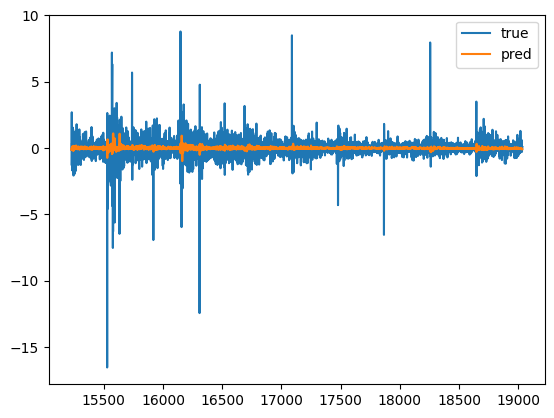

In [ ]:
X_test['pred'] = predictions
X_test['true'] = y_test
tsla_true = X_test.query('ticker_name == "TSLA"').true
tsla_pred = X_test.query('ticker_name == "TSLA"').pred
plt.plot(tsla_true)
plt.plot(tsla_pred)
plt.legend(['true', 'pred'])

In [ ]:
cols = ['Close', 'High', 'Low', 'Open', 'Volume']

# X_test = X_test.set_index(['ticker_name', 'Datetime'])
trades_df = simulate_trades_smart_multi_buy(X_test[cols],
                                            X_test['pred'],
                                            initial_capital=100000,
                                            commission_rate=0.01,
                                            risk_per_trade=1,
                                            threshold_buy=0.01,
                                            threshold_sell=-0.01)

In [ ]:
analysis_results = analyze_trades(trades_df)
for metric, value in analysis_results.items():
    print(f"{metric}: {value:.2f}")

Total Profit: 2386.54
Total Return (%): 2.39
Maximum Drawdown: 55816.97
Win Rate (%): 49.32
Number of Winning Trades: 21182.00
Number of Losing Trades: 21765.00


# Градиентный бустинг

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

if __name__ == '__main__':

    df_classic = reset_dataset()
    df_classic = df_classic.groupby('ticker_name', group_keys=False).apply(create_target_magnitude)

    X_train, X_test, y_train, y_test = train_test_split_series_split(df_classic)

    numeric_features = X_train.select_dtypes(include=['number']).columns.tolist()  # Автоматический выбор числовых столбцов
    categorical_features = ['ticker_name']
    target_column = 'Target'

    model = GradientBoostingRegressor(random_state=42)

    pipeline = TradingPipeline(model, numeric_features, categorical_features)
    pipeline.fit(X_train, y_train)

    predictions = pipeline.predict(X_test)

    mse = pipeline.evaluate(X_test, y_test, mean_squared_error)
    mape = pipeline.evaluate(X_test, y_test, mean_absolute_percentage_error)

    print(f"MSE: {mse}, MAPE: {mape}")

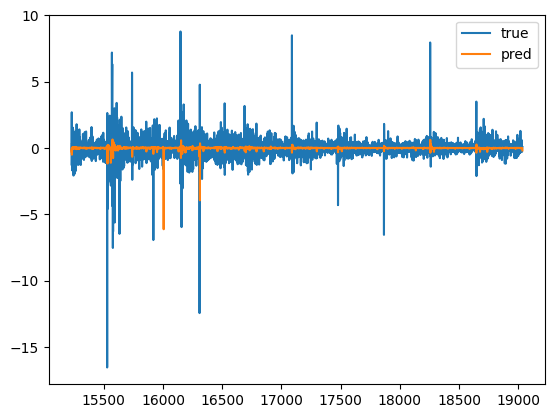

In [ ]:
X_test['pred'] = predictions
X_test['true'] = y_test
tsla_true = X_test.query('ticker_name == "TSLA"').true
tsla_pred = X_test.query('ticker_name == "TSLA"').pred
plt.plot(tsla_true)
plt.plot(tsla_pred)
plt.legend(['true', 'pred'])

In [ ]:
cols = ['Close', 'High', 'Low', 'Open', 'Volume']

X_test = X_test.set_index(['ticker_name', 'Datetime'])

trades_df = simulate_trades_smart_multi_buy(X_test[cols],
                                            X_test['pred'],
                                            initial_capital=100000,
                                            commission_rate=0.01,
                                            risk_per_trade=1,
                                            threshold_buy=0.01,
                                            threshold_sell=-0.01)

In [ ]:
analysis_results = analyze_trades(trades_df)
for metric, value in analysis_results.items():
    print(f"{metric}: {value:.2f}")

Total Profit: 9483.53
Total Return (%): 9.48
Maximum Drawdown: 57214.07
Win Rate (%): 49.93
Number of Winning Trades: 21096.00
Number of Losing Trades: 21153.00


# Catboost

In [19]:
# !pip install catboost

In [20]:
from catboost import CatBoostRegressor

if __name__ == '__main__':

    df_classic = reset_dataset()
    df_classic = df_classic.groupby('ticker_name', group_keys=False).apply(create_target_magnitude)

    X_train, X_test, y_train, y_test = train_test_split_series_split(df_classic)

    numeric_features = X_train.select_dtypes(include=['number']).columns.tolist()  # Автоматический выбор числовых столбцов
    categorical_features = ['ticker_name']
    target_column = 'Target'

    model = CatBoostRegressor(
            depth=8,
            learning_rate=0.1,
            iterations=1000,
            loss_function='RMSE',
            eval_metric='MAPE',
            random_seed=42,
            verbose=50
    )

    pipeline = TradingPipeline(model, numeric_features, categorical_features)
    pipeline.fit(X_train, y_train)

    predictions = pipeline.predict(X_test)

    mse = mean_squared_error(predictions, y_test)
    mape = mean_absolute_percentage_error(predictions[y_test != 0], y_test[y_test != 0])

    print(f"MSE: {mse}, MAPE: {mape}")

0:	learn: 0.2302586	total: 216ms	remaining: 3m 36s
50:	learn: 0.2290481	total: 6.71s	remaining: 2m 4s
100:	learn: 0.2275624	total: 14.6s	remaining: 2m 10s
150:	learn: 0.2259654	total: 21.1s	remaining: 1m 58s
200:	learn: 0.2241191	total: 32.2s	remaining: 2m 7s
250:	learn: 0.2222764	total: 40s	remaining: 1m 59s
300:	learn: 0.2206977	total: 46.4s	remaining: 1m 47s
350:	learn: 0.2188407	total: 54s	remaining: 1m 39s
400:	learn: 0.2172216	total: 1m	remaining: 1m 30s
450:	learn: 0.2154495	total: 1m 8s	remaining: 1m 23s
500:	learn: 0.2137260	total: 1m 14s	remaining: 1m 14s
550:	learn: 0.2122226	total: 1m 22s	remaining: 1m 7s
600:	learn: 0.2104207	total: 1m 30s	remaining: 1m
650:	learn: 0.2088455	total: 1m 37s	remaining: 52.4s
700:	learn: 0.2075220	total: 1m 45s	remaining: 45s
750:	learn: 0.2059892	total: 1m 52s	remaining: 37.1s
800:	learn: 0.2044897	total: 1m 59s	remaining: 29.8s
850:	learn: 0.2029103	total: 2m 6s	remaining: 22.2s
900:	learn: 0.2014363	total: 2m 20s	remaining: 15.4s
950:	learn

In [21]:
cols = ['Close', 'High', 'Low', 'Open', 'Volume']

X_test = X_test.set_index(['ticker_name', 'Datetime'])
X_test['pred'] = predictions

trades_df = simulate_trades_smart_multi_buy(X_test[cols],
                                            X_test['pred'],
                                            initial_capital=100000,
                                            commission_rate=0.01,
                                            risk_per_trade=1,
                                            threshold_buy=0.01,
                                            threshold_sell=-0.01)

In [22]:
analysis_results = analyze_trades(trades_df)
for metric, value in analysis_results.items():
    print(f"{metric}: {value:.2f}")

Total Profit: 8276.22
Total Return (%): 8.28
Maximum Drawdown: 57100.75
Win Rate (%): 49.10
Number of Winning Trades: 21160.00
Number of Losing Trades: 21936.00


# Catboost (RMSE with uncertainty)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
from catboost import CatBoostRegressor

if __name__ == '__main__':

    df_classic = reset_dataset()
    df_classic = df_classic.groupby('ticker_name', group_keys=False).apply(create_target_magnitude)

    X_train, X_test, y_train, y_test = train_test_split_series_split(df_classic)

    numeric_features = X_train.select_dtypes(include=['number']).columns.tolist()  # Автоматический выбор числовых столбцов
    categorical_features = ['ticker_name']
    target_column = 'Target'

    model = CatBoostRegressor(
            iterations=100,
            loss_function='RMSEWithUncertainty',
            eval_metric='RMSEWithUncertainty',
            random_seed=42,
            verbose=False
    )

    pipeline = TradingPipeline(model, numeric_features, categorical_features)

    # Сетка параметров для подбора
    param_grid = {
        # # Параметры для numeric_transformer (StandardScaler)
        # 'numeric_transformer__with_mean': [True, False],
        # 'numeric_transformer__with_std': [True, False],

        # # Параметры для categorical_transformer (OneHotEncoder)
        # 'categorical_transformer__handle_unknown': ['ignore', 'infrequent_if_exist'],

        # Параметры модели CatBoost
        # 'model__depth': [2, 4, 6, 8],
        'model__depth': [1, 2, 4],
        # 'model__learning_rate': [0.001, 0.005, 0.01, 0.1]
        'model__learning_rate': [0.001, 0.005, 0.01]
    }

    # Для RandomizedSearchCV
    randomized_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid,
        scoring='neg_mean_squared_error',
        cv=5,
        verbose=1,
        n_jobs=-1  # параллельные вычисления
    )

    # Запуск поиска
    randomized_search.fit(X_train, y_train)

    print("Лучшие параметры:", randomized_search.best_params_)
    print("Лучшая точность:", randomized_search.best_score_)

    # Использование лучшей модели для предсказаний
    best_model = randomized_search.best_estimator_
    predictions = best_model.predict(X_test)

    mse = mean_squared_error(predictions[:, 0], y_test)
    mape = mean_absolute_percentage_error(predictions[y_test != 0, 0], y_test[y_test != 0])

    print(f"MSE: {mse}, MAPE: {mape}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Лучшие параметры: {'model__learning_rate': 0.001, 'model__depth': 1}
Лучшая точность: nan
MSE: 1.0316219797125914, MAPE: 94.77677320019689


In [30]:
# mean = predictions[:, 0]
# std = np.sqrt(np.exp(predictions[:, 1]))

# lower_bound = mean - 1.96 * std
# upper_bound = mean + 1.96 * std

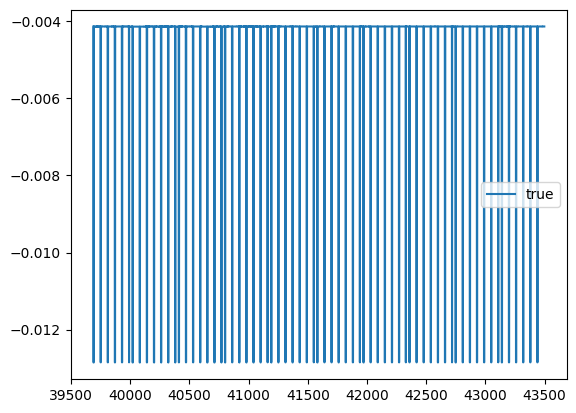

In [ ]:
# X_test.reset_index(inplace=True)
X_test['pred'] = predictions[:, 0]
X_test['true'] = y_test.reset_index(drop=True)
tsla_true = X_test.query('ticker_name == "TSLA"').true
tsla_pred = X_test.query('ticker_name == "TSLA"').pred
# plt.plot(tsla_true)
plt.plot(tsla_pred)
plt.legend(['true', 'pred'])

## Адаптивная стратегия

In [ ]:
import pandas as pd
import numpy as np
import math
import scipy.stats as st

def calculate_volume(current_std, max_position_size, historical_max_std):
    """Расчёт объёма позиции на основе текущей неопределённости"""
    confidence = 1 - (current_std / historical_max_std)
    return int(max_position_size * np.clip(confidence, 0.1, 1))  # Не опускаемся ниже 10%


def simulate_trades_uncertainty(df,
                                predictions,
                                historical_max_std,
                                initial_capital=100000,
                                commission_rate=0.01,
                                threshold = 0.01):

  portfolio = {}
  trades = []
  cash = initial_capital
  last_action = None

  for (ticker, date), prediction_data in predictions.items():
      current_price = df.loc[(ticker, date), 'Close']
      mean = prediction_data['mean']
      log_variance = prediction_data['log_variance']
      se = np.sqrt(np.exp(log_variance))

      if ticker not in portfolio:
        portfolio[ticker] = {'cash': cash, 'positions': 0, 'last_action': 'none'}

      cash = portfolio[ticker]['cash']
      positions = portfolio[ticker]['positions']
      last_action = portfolio[ticker]['last_action']

      action = 'hold'
      if mean > threshold and last_action != 'buy':
        action = 'buy'
      elif mean < -threshold and last_action != 'sell' and last_action:
        action = 'sell'
      shares_to_sell, shares_to_buy = 0, 0

      if action == 'buy':

          shares_to_buy = math.floor(cash / (current_price * (1 + commission_rate)))
          print
          shares_to_buy = calculate_volume(se,
                                           shares_to_buy,
                                           historical_max_std)

          if shares_to_buy > 0:
              cost = shares_to_buy * current_price * (1 + commission_rate)
              if cost <= cash:
                  cash -= cost
                  positions += shares_to_buy
                  portfolio[ticker]['cash'] = cash
                  portfolio[ticker]['positions'] = positions
                  portfolio[ticker]['last_action'] = 'buy'
              else:
                  shares_to_buy = 0 # not enough cash
                  action = 'hold'

      elif action == 'sell' and positions > 0:
        shares_to_sell = positions
        if shares_to_sell > 0:  # Check if sell
            cash_from_sell = shares_to_sell * current_price * (1 - commission_rate)
            cash += cash_from_sell
            positions -= shares_to_sell
            portfolio[ticker]['cash'] = cash
            portfolio[ticker]['positions'] = positions
            portfolio[ticker]['last_action'] = 'sell'


      trades.append({
            'ticker': ticker,
            'date': date,
            'action': action,
            'price': current_price,
            'shares': shares_to_buy if action == "buy" else (shares_to_sell if action == "sell" else 0),
            'cash': cash, # Use current cash for the ticker
            'positions': positions, # Use current positions for the ticker
            'total_value': cash + positions * current_price, # Corrected total value
            'std': se
        })

      portfolio[ticker]['cash'] = cash
      portfolio[ticker]['positions'] = positions
      portfolio[ticker]['last_action'] = action

  trades_df = pd.DataFrame(trades)
  trades_df.set_index(['ticker', 'date'], inplace=True)
  return trades_df

In [ ]:
cols = ['Close', 'High', 'Low', 'Open', 'Volume']
preds = [{'mean': float(val[0]), 'log_variance': float(val[1])} for val in predictions]
historical_max_std = np.sqrt(np.exp(predictions[:, 1])).max()

# X_test = X_test.set_index(['ticker_name', 'Datetime'])
X_test['pred'] = preds

# Run the Simulation
trades_df = simulate_trades_uncertainty(
    X_test[cols].copy(),  # Always use .copy()
    X_test['pred'].copy(),
    historical_max_std=historical_max_std,
    initial_capital=100000,
    commission_rate=0.01,
    threshold = 0
  )

In [ ]:
analysis_results = analyze_trades(trades_df)
for metric, value in analysis_results.items():
    print(f"{metric}: {value:.2f}")

Total Profit: 0.00
Total Return (%): 0.00
Maximum Drawdown: 0.00
Win Rate (%): 0.00
Number of Winning Trades: 0.00
Number of Losing Trades: 0.00


# RL для стратегии
## Реализация торговой среды

In [28]:
# !pip install stable_baselines3
# !pip install 'shimmy>=2.0'

<ipython-input-9-65295f92ddb7>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('ticker_name', group_keys=False).apply(new_price_features)
<ipython-input-9-65295f92ddb7>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('ticker_name', group_keys=False).apply(new_returns_features)
<ipython-input-9-65295f92ddb7>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the group

Using cpu device


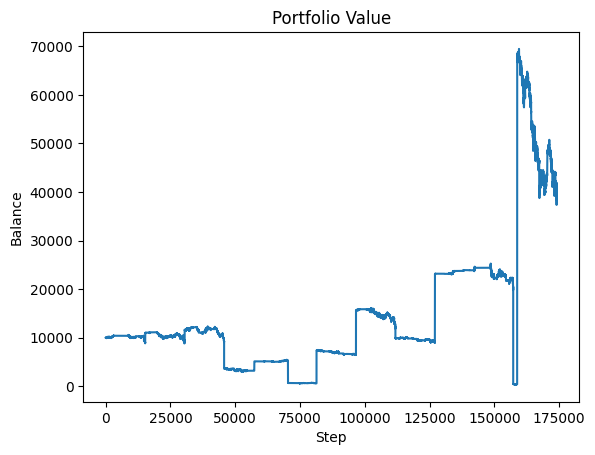

In [43]:
import gym
from gym import spaces
import numpy as np
import pandas as pd
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Создание среды
class TradingEnv(gym.Env):
    def __init__(self, df, initial_balance=10000):
        self.df = df
        self.initial_balance = initial_balance
        self.current_step = 0
        self.portfolio_values = [] # Для стратегия с Risk-adjusted (Sharpe Ratio):

        # Пространство действий: 0=HOLD, 1=BUY, 2=SELL
        self.action_space = spaces.Discrete(3)

        # Пространство состояний: рыночные данные + баланс + позиция
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(len(df.columns) + 2,),
            dtype=np.float32
        )

        self.reset()

    def reset(self):
        self.balance = self.initial_balance
        self.position = 0
        self.current_step = 0
        return self._next_observation()

    def _next_observation(self):
        features = self.df.iloc[self.current_step].values.astype(np.float32)
        return np.append(features, [self.balance, self.position])

    def step(self, action):
        current_price = self.df.iloc[self.current_step]['Close']
        prev_balance = self.balance

        # Execute action
        if action == 1:  # BUY
            if self.balance >= current_price:
                self.position += 1
                self.balance -= current_price
        elif action == 2:  # SELL
            if self.position > 0:
                self.position -= 1
                self.balance += current_price

        # Calculate reward
        # reward = self.balance - prev_balance
        # reward = (self.balance - prev_balance) / prev_balance

        new_value = self.balance + self.position * current_price
        self.portfolio_values.append(new_value)

        returns = np.diff(self.portfolio_values)
        reward = returns[-1] if len(returns) > 0 else 0

        # Move to next step
        self.current_step += 1
        done = self.current_step >= len(self.df) - 1

        return self._next_observation(), reward, done, {}

# 2. Обучение агента
def train_rl_agent(data):
    env = DummyVecEnv([lambda: TradingEnv(data)])
    model = DQN('MlpPolicy', env,
               learning_rate=0.0001,
               buffer_size=10000,
               exploration_final_eps=0.02,
               verbose=1)
    model.learn(total_timesteps=100000)
    return model

# 4. Интеграция с TradingPipeline
class RLEnhancedStrategy:
    def __init__(self, rl_model):
        self.rl_model = rl_model
        self.current_balance = 100000
        self.position = 0

    def make_decision(self, market_state):
        # market_state должен быть предобработанным вектором признаков
        action, _ = self.rl_model.predict(market_state)
        return action

# 5. Бэктестинг
def backtest(model, data):
    env = TradingEnv(data)
    obs = env.reset()
    portfolio = []

    while True:
        action, _ = model.predict(obs)
        obs, reward, done, _ = env.step(action)
        portfolio.append(env.balance + env.position * env.df.iloc[env.current_step]['Close'])
        if done:
            break

    returns = np.diff(portfolio)

    plt.plot(portfolio)
    plt.title('Portfolio Value')
    plt.xlabel('Step')
    plt.ylabel('Balance')
    plt.show()

# Запуск полного цикла
if __name__ == "__main__":
    # Подготовка данных
    data = reset_dataset()
    data = create_target_magnitude(data, future_period=1)
    X_train, X_test, y_train, y_test = train_test_split_series_split(data)
    X_train.drop(
        ['Datetime', 'ticker_name', 'share_name'],
        inplace=True,
        axis=1
    )

    X_test.drop(
        ['Datetime', 'ticker_name', 'share_name'],
        inplace=True,
        axis=1
    )

    # Обучение модели
    model = train_rl_agent(X_train)

    # Сохранение модели
    model.save("rl_trading_model_sharpe_ratio")

    # Бэктестинг
    backtest(model, X_train)

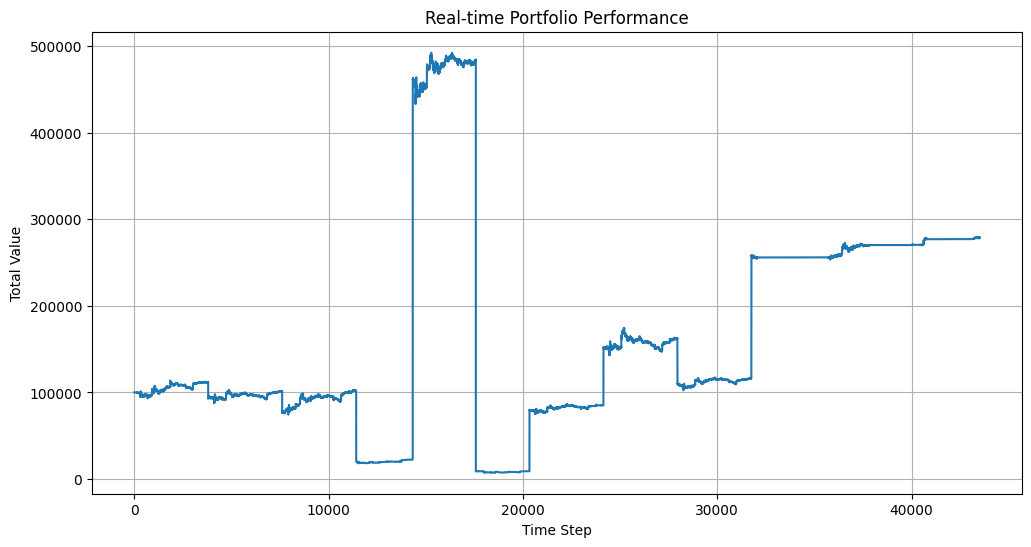


Final Portfolio Value: 278915.5524851084


In [45]:
# 6. Пакетная обработка новых данных
class RealTimeTrading:
    def __init__(self, model, initial_balance=100000):
        self.model = model
        self.balance = initial_balance
        self.position = 0
        self.portfolio_history = []
        self.current_state = None

    def process_new_data(self, new_data: pd.DataFrame):
        """Обработка нового блока данных"""
        # 1. Предобработка как в prepare_data()
        processed_data = new_data.copy()

        # 2. Последовательная обработка каждого временного шага
        for idx in range(len(processed_data)):
            state = self._create_state(processed_data.iloc[idx])
            action = self._make_decision(state)
            self._execute_trade(action, processed_data.iloc[idx]['Close'])

            # Логирование
            # self._log_state(idx, action, processed_data.iloc[idx]['Close'])


    def _create_state(self, row):
        """Создание вектора состояния"""
        features = row.values.astype(np.float32)
        return np.append(features, [self.balance, self.position])

    def _make_decision(self, state):
        """Предсказание действия"""
        action, _ = self.model.predict(state)
        return action

    def _execute_trade(self, action, price):
        """Исполнение торгового действия"""
        if action == 1:  # BUY
            if self.balance >= price:
                self.position += 1
                self.balance -= price
        elif action == 2:  # SELL
            if self.position > 0:
                self.position -= 1
                self.balance += price

        self.portfolio_history.append(self.balance + self.position * price)

    # def _log_state(self, step, action, price):
    #     """Логирование результатов"""
    #     print(f"\nStep: {step}")
    #     print(f"Price: {price:.2f}")
    #     print(f"Action: {['HOLD', 'BUY', 'SELL'][action]}")
    #     print(f"Balance: {self.balance:.2f}")
    #     print(f"Position: {self.position}")
    #     print(f"Portfolio Value: {self.portfolio_history[-1]:.2f}")
    #     print("-" * 40)

    def plot_performance(self):
        """Визуализация результатов"""
        plt.figure(figsize=(12,6))
        plt.plot(self.portfolio_history)
        plt.title('Real-time Portfolio Performance')
        plt.xlabel('Time Step')
        plt.ylabel('Total Value')
        plt.grid(True)
        plt.show()

# Пример использования
if __name__ == "__main__":
    # Загрузка модели и scaler
    model = DQN.load("rl_trading_model_sharpe_ratio")

    trading_system = RealTimeTrading(model)
    # Эмуляция потоковых данных (загрузка новых данных)
    new_data_batch = X_test
    # Обработка данных
    trading_system.process_new_data(new_data_batch)

    # Визуализация результатов
    trading_system.plot_performance()

    # Пример вывода текущего состояния
    print("\nFinal Portfolio Value:", trading_system.portfolio_history[-1])

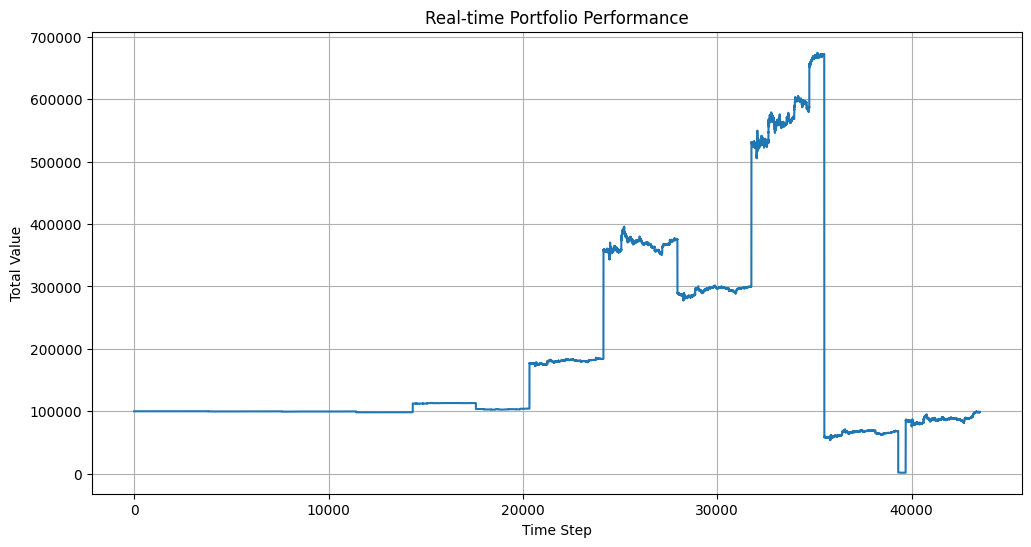


Final Portfolio Value: 98977.42481338978


In [46]:
# Пример использования
if __name__ == "__main__":
    # Загрузка модели и scaler
    model = DQN.load("rl_trading_model_percent_target")

    trading_system = RealTimeTrading(model)
    # Эмуляция потоковых данных (загрузка новых данных)
    new_data_batch = X_test
    # Обработка данных
    trading_system.process_new_data(new_data_batch)

    # Визуализация результатов
    trading_system.plot_performance()

    # Пример вывода текущего состояния
    print("\nFinal Portfolio Value:", trading_system.portfolio_history[-1])

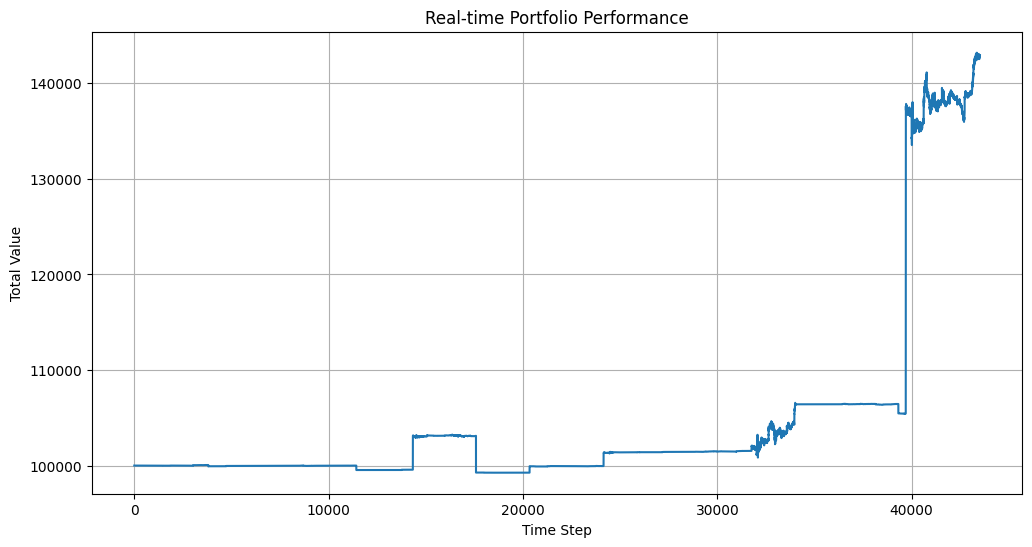


Final Portfolio Value: 142929.0885298252


In [42]:
# Пример использования
if __name__ == "__main__":
    # Загрузка модели и scaler
    model = DQN.load("rl_trading_model")

    trading_system = RealTimeTrading(model)
    # Эмуляция потоковых данных (загрузка новых данных)
    new_data_batch = X_test
    # Обработка данных
    trading_system.process_new_data(new_data_batch)

    # Визуализация результатов
    trading_system.plot_performance()

    # Пример вывода текущего состояния
    print("\nFinal Portfolio Value:", trading_system.portfolio_history[-1])

# Черновик

## Вариант 2. Direction of Price Movement (Направление движения цены)

In [ ]:
def create_target_direction(df, future_period=1): # 5 - future_period, количество периодов вперед
    """Создает целевую переменную для направления движения цены."""
    df['Future_Price'] = df['Close'].shift(-future_period)  # Цена через future_period
    df['Price_Change'] = df['Future_Price'] - df['Close']
    df['Target'] = np.where(df['Price_Change'] > 0, 1, np.where(df['Price_Change'] < 0, -1, 0))
    df.dropna(inplace=True)
    df.drop(['Future_Price', 'Price_Change'], inplace=True)
    return df

In [ ]:
# Убедитесь, что mask содержит булевы значения для числовых столбцов
numeric_features = X_train.select_dtypes(include=['number']).columns.tolist()  # Автоматический выбор числовых столбцов
categorical_features = ['ticker_name']

# Создайте трансформеры
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # Для плотного массива

# Конфигурация ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'  # Лучше явно указать ненужные столбцы
)

# Создайте пайплайн
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regression', LogisticRegression())
])

# Проверьте данные перед обучением
print("Проверка столбцов в X_train:", X_train.columns.tolist())
print("Числовые столбцы:", numeric_features)
print("Категориальные столбцы:", categorical_features)

# Запустите обучение
pipeline.fit(X_train, y_train)

In [ ]:
predictions = pipeline.predict(X_test)

In [ ]:
X_test['pred'] = predictions
X_test['true'] = y_test

In [ ]:
cols = ['Close', 'High', 'Low', 'Open', 'Volume']

X_test_aapl = X_test.reset_index().query("ticker_name == 'AAPL'").set_index(['ticker_name', 'Datetime'])

trades_df = simulate_trades_price_change(X_test_aapl[cols], X_test_aapl['pred'],
                             initial_capital=100000,
                             commission_rate=0.01)

In [ ]:
analysis_results = analyze_trades(trades_df)

for metric, value in analysis_results.items():
    print(f"{metric}: {value:.2f}")

## Future Return (Будущая доходность)

In [ ]:
def create_target_return(df, future_period=5):
    """Создает целевую переменную для будущей доходности."""
    df['Future_Price'] = df['Close'].shift(-future_period)
    df['Target_Return'] = np.log(df['Future_Price'] / df['Close'])
    df.dropna(inplace=True)
    df.drop('Future_Price', inplace=True)
    return df

## Probability of Crossing a Threshold (Вероятность пересечения порога)

In [ ]:
# (Пример - упрощенный, требует доработки)
def create_target_probability(df, threshold, future_period=5):
    """Создает целевую переменную для вероятности достижения порога."""
    df['Future_High'] = df['High'].rolling(window=future_period).max().shift(-future_period) # Наибольшая цена за период
    df['Target_Probability'] = np.where(df['Future_High'] >= threshold, 1, 0) # Если цена достигла порога, то 1, иначе 0

    df.dropna(inplace=True)
    return df

In [ ]:
import pandas as pd
import numpy as np

def simulate_trades(df, predictions, initial_capital=100000, commission_rate=0.001):
    """
    Симмулирует торговлю на основе предсказаний и рассчитывает показатели.

    Args:
        df (pd.DataFrame): DataFrame с историческими данными (должен содержать 'close', 'volume' и индексы даты и тикера).
        predictions (pd.Series): Series с предсказаниями (1 - купить, -1 - продать, 0 - держать). Индекс должен соответствовать df.
        initial_capital (float): Начальный капитал.
        commission_rate (float): Комиссия за сделку (в долях, например, 0.001 для 0.1%).

    Returns:
        pd.DataFrame: DataFrame с результатами симуляции (покупка/продажа, количество акций, цена, баланс, количество акций, общий баланс).
    """

    # 1. Инициализация
    positions = 0  # Количество акций
    cash = initial_capital
    trades = []  # Список для хранения информации о сделках
    last_prediction = 0  # Сохраняем предыдущее предсказание для исключения повторных сигналов

    # 2. Итерируемся по данным, используя индексы для корректного сопоставления
    for (ticker, date), prediction in predictions.items():
        try:
            current_price = df.loc[(ticker, date), 'close']  # Получаем цену закрытия
            volume = df.loc[(ticker, date), 'volume'] # Получаем объем
        except KeyError:
            # Если данных о цене или объеме нет, пропускаем
            print(f"Пропуск данных для {ticker} {date} (нет цены или объема).")
            continue

        # 3. Определяем действия (если предсказание отличается от предыдущего)
        if prediction != last_prediction:
            if prediction == 1:  # Купить
                # Покупаем акции (максимум, на что хватает денег)
                shares_to_buy = int(cash / (current_price * (1 + commission_rate)))  # Учитываем комиссию
                if shares_to_buy > 0:
                    cost = shares_to_buy * current_price * (1 + commission_rate)
                    cash -= cost
                    positions += shares_to_buy
                    trades.append({
                        'ticker': ticker,
                        'date': date,
                        'action': 'buy',
                        'price': current_price,
                        'shares': shares_to_buy,
                        'cash': cash,
                        'positions': positions,
                        'total_value': cash + positions * current_price
                    })
            elif prediction == -1:  # Продать
                if positions > 0:  # Продаем только если есть акции
                    sell_value = positions * current_price * (1 - commission_rate)  # Учитываем комиссию
                    cash += sell_value
                    trades.append({
                        'ticker': ticker,
                        'date': date,
                        'action': 'sell',
                        'price': current_price,
                        'shares': positions,
                        'cash': cash,
                        'positions': 0,
                        'total_value': cash  # Общий баланс - только наличные
                    })
                    positions = 0 # Обнуляем количество акций
            last_prediction = prediction # Обновляем последнее предсказание

            elif prediction == 0:
                last_prediction = 0
        # 4.  Если предсказание равно 0 (держать) и есть открытые позиции,  обновляем общий баланс
        elif positions > 0:
                trades.append({
                    'ticker': ticker,
                    'date': date,
                    'action': 'hold',
                    'price': current_price,
                    'shares': positions,
                    'cash': cash,
                    'positions': positions,
                    'total_value': cash + positions * current_price
                })
        else: # если позиций нет, и предсказание "держать" - ничего не делаем

            trades.append({
                'ticker': ticker,
                'date': date,
                'action': 'hold',
                'price': current_price,
                'shares': 0,
                'cash': cash,
                'positions': 0,
                'total_value': cash
            })
        #else: #Если предсказание равно предыдущему, ничего не делаем
    # 5.  Создаем DataFrame из списка сделок
    trades_df = pd.DataFrame(trades)
    trades_df.set_index(['ticker', 'date'], inplace=True) # Устанавливаем мультииндекс
    return trades_df

In [ ]:
# 3. Определяем действия
        # if predicted_change > threshold and last_action != 'buy':  # Купить, если предсказанное изменение выше порога
        #     # Покупаем акции (максимум, на что хватает денег)
        #     shares_to_buy = int(cash / (current_price * (1 + commission_rate)))  # Учитываем комиссию
        #     if shares_to_buy > 0:
        #         cost = shares_to_buy * current_price * (1 + commission_rate)
        #         cash -= round(cost, 2)
        #         positions += shares_to_buy
        #         trades.append({
        #             'ticker': ticker,
        #             'date': date,
        #             'action': 'buy',
        #             'price': current_price,
        #             'shares': shares_to_buy,
        #             'cash': cash,
        #             'positions': positions,
        #             'total_value': cash + positions * current_price
        #         })
        #         last_action = 'buy'
        # elif predicted_change < -threshold and last_action != 'sell':  # Продать, если предсказанное изменение ниже порога
        #     if positions > 0:  # Продаем только если есть акции
        #         sell_value = positions * current_price * (1 - commission_rate)  # Учитываем комиссию
        #         cash += round(sell_value, 2)
        #         trades.append({
        #             'ticker': ticker,
        #             'date': date,
        #             'action': 'sell',
        #             'price': current_price,
        #             'shares': positions,
        #             'cash': cash,
        #             'positions': 0,
        #             'total_value': cash  # Общий баланс - только наличные
        #         })
        #         positions = 0
        #         last_action = 'sell'
        # else:  # Держать
        #     trades.append({
        #         'ticker': ticker,
        #         'date': date,
        #         'action': 'hold',
        #         'price': current_price,
        #         'shares': positions,
        #         'cash': cash,
        #         'positions': positions,
        #         'total_value': cash + positions * current_price
        #     })

## Градиентный бустинг

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Убедитесь, что mask содержит булевы значения для числовых столбцов
numeric_features = X_train.select_dtypes(include=['number']).columns.tolist()  # Автоматический выбор числовых столбцов
categorical_features = ['ticker_name']

# Создайте трансформеры
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # Для плотного массива

# Конфигурация ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'  # Лучше явно указать ненужные столбцы
)

# Создайте пайплайн
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regression', GradientBoostingRegressor(random_state=42))
])

# Проверьте данные перед обучением
print("Проверка столбцов в X_train:", X_train.columns.tolist())
print("Числовые столбцы:", numeric_features)
print("Категориальные столбцы:", categorical_features)

# Запустите обучение
pipeline.fit(X_train, y_train)

Проверка столбцов в X_train: ['Datetime', 'Close', 'High', 'Low', 'Open', 'Volume', 'share_name', 'ticker_name', 'Returns', 'minute', 'hour', 'day', 'weekday', 'minute_sin', 'minute_cos', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'weekday_sin', 'weekday_cos', 'ratio_lag_1', 'ratio_diff_lag_1', 'ratio_mean_lag_1', 'ratio_diff_mean_lag_1', 'ratio_exp_mean_lag_1', 'ratio_lag_2', 'ratio_diff_lag_2', 'ratio_mean_lag_2', 'ratio_diff_mean_lag_2', 'ratio_exp_mean_lag_2', 'ratio_lag_3', 'ratio_diff_lag_3', 'ratio_mean_lag_3', 'ratio_diff_mean_lag_3', 'ratio_exp_mean_lag_3', 'ratio_lag_4', 'ratio_diff_lag_4', 'ratio_mean_lag_4', 'ratio_diff_mean_lag_4', 'ratio_exp_mean_lag_4', 'ratio_lag_14', 'ratio_diff_lag_14', 'ratio_mean_lag_14', 'ratio_diff_mean_lag_14', 'ratio_exp_mean_lag_14', 'ratio_lag_29', 'ratio_diff_lag_29', 'ratio_mean_lag_29', 'ratio_diff_mean_lag_29', 'ratio_exp_mean_lag_29', 'ratio_lag_59', 'ratio_diff_lag_59', 'ratio_mean_lag_59', 'ratio_diff_mean_lag_59', 'ratio_exp_mean_la

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Close', 'High', 'Low',
                                                   'Open', 'Volume', 'Returns',
                                                   'minute_sin', 'minute_cos',
                                                   'hour_sin', 'hour_cos',
                                                   'day_sin', 'day_cos',
                                                   'weekday_sin', 'weekday_cos',
                                                   'ratio_lag_1',
                                                   'ratio_diff_lag_1',
                                                   'ratio_mean_lag_1',
                                                   'ratio_diff_mean_lag_1',
                                                   'ratio_exp_mean_lag_1',
                                                   'ratio_lag_2',
                                                   'ratio_diff_lag_2',
                                                   'ratio_mean_lag_2',
                                                   'ratio_diff_mean_lag_2',
                                                   'ratio_exp_mean_lag_2',
                                                   'ratio_lag_3',
                                                   'ratio_diff_lag_3',
                                                   'ratio_mean_lag_3',
                                                   'ratio_diff_mean_lag_3',
                                                   'ratio_exp_mean_lag_3',
                                                   'ratio_lag_4', ...]),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['ticker_name'])])),
                ('regression', GradientBoostingRegressor(random_state=42))])

In [ ]:
predictions = pipeline.predict(X_test)

rmse = sqrt(mean_squared_error(y_test, predictions))
mape = mean_absolute_percentage_error(y_test, predictions)

mape

449807357859.28265

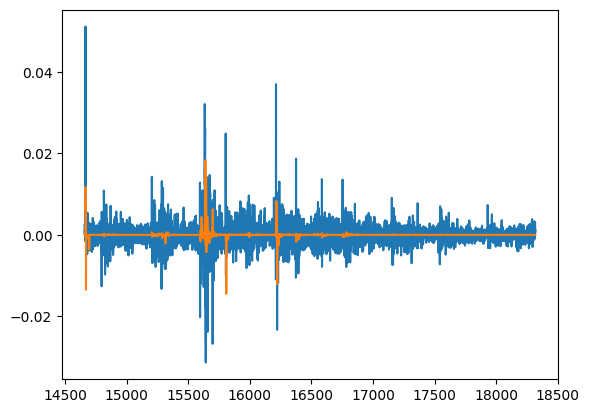

In [ ]:
import matplotlib.pyplot as plt

X_test['pred'] = predictions
X_test['true'] = y_test
tsla_pred = X_test.query('ticker_name == "TSLA"').pred
tsla_true = X_test.query('ticker_name == "TSLA"').true
plt.plot(tsla_true)
plt.plot(tsla_pred)

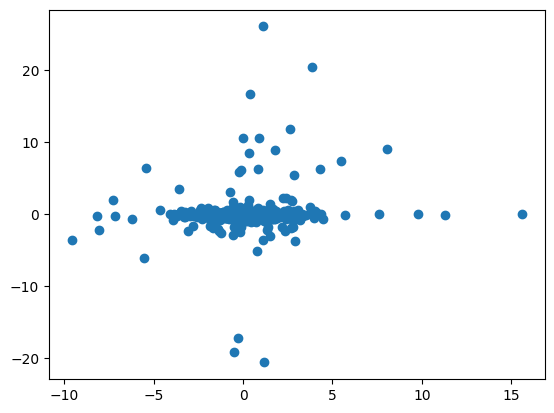

In [ ]:
tsla_true_normalized = (tsla_true - tsla_true.mean())/tsla_true.std()
tsla_pred_normalized = (tsla_pred - tsla_pred.mean())/tsla_pred.std()

plt.scatter(tsla_true_normalized, tsla_pred_normalized)

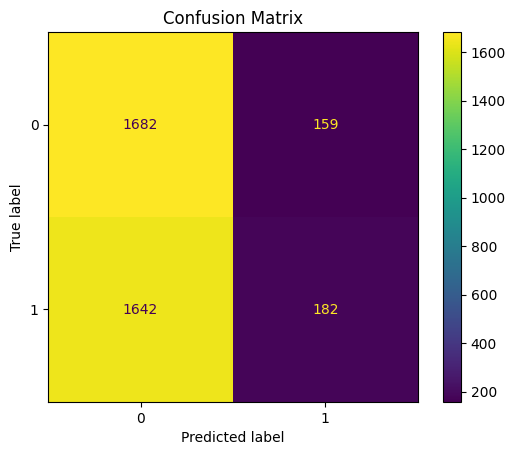

In [ ]:
tsla_true_bin = tsla_true > 0
tsla_pred_bin = tsla_pred > 0

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(tsla_true_bin, tsla_pred_bin)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()